In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import norm

import urllib.request, json
import requests
import urllib.parse
import datetime

# Retrieve Covariates Data from NYC Open Data Portal

Aggregate the following datasets to monthly counts. The question would be whether or not we want to normalize these based on either city population (crime) and inmate population. The issue with normalizing on inmate population for the inmate/staff related incidents is that we do not have aggregated monthly jail population, just change in population. We should also consider using scaling laws to normalize crime counts rather than a per capita metric.


### Socrata API urls:

* Crime Rates: `https://data.cityofnewyork.us/resource/qgea-i56i.json`


* Inmate Assault on Staff: `https://data.cityofnewyork.us/resource/erra-pzy8.json`


* Inmate Incidents - Inmate Fights: `https://data.cityofnewyork.us/resource/k548-32d3.json`


* Inmate Incidents - Slashing and Stabbing: `https://data.cityofnewyork.us/resource/gakf-suji.json`

#### Covariate 1: Crime Counts

In [2]:
#retrieve monthly crime counts from Jan 1, 2014 through most recent month
crime_historical = 'https://data.cityofnewyork.us/resource/qgea-i56i.json'
crime_yeartodate = 'https://data.cityofnewyork.us/resource/5uac-w243.json'

In [3]:
query = (crime_historical+'?'
            "$select=min(CMPLNT_FR_DT),max(CMPLNT_FR_DT)"
            "&$where=CMPLNT_FR_DT >= '2014-01-01T00:00:00'")
query = query.replace(" ", "%20")
print(query)
response = urllib.request.urlopen(query)
data = json.loads(response.read())

https://data.cityofnewyork.us/resource/qgea-i56i.json?$select=min(CMPLNT_FR_DT),max(CMPLNT_FR_DT)&$where=CMPLNT_FR_DT%20>=%20'2014-01-01T00:00:00'


In [4]:
data

[{'min_CMPLNT_FR_DT': '2014-01-01T00:00:00.000',
  'max_CMPLNT_FR_DT': '2022-12-31T00:00:00.000'}]

In [5]:
query = (crime_yeartodate+'?'
            "$select=min(CMPLNT_FR_DT),max(CMPLNT_FR_DT)"
            "&$where=CMPLNT_FR_DT >= '2023-01-01T00:00:00'")
query = query.replace(" ", "%20")
print(query)
response = urllib.request.urlopen(query)
data = json.loads(response.read())

https://data.cityofnewyork.us/resource/5uac-w243.json?$select=min(CMPLNT_FR_DT),max(CMPLNT_FR_DT)&$where=CMPLNT_FR_DT%20>=%20'2023-01-01T00:00:00'


In [6]:
data

[{'min_CMPLNT_FR_DT': '2023-01-01T00:00:00.000',
  'max_CMPLNT_FR_DT': '2023-03-31T00:00:00.000'}]

In [7]:
def get_crime_data(url,min_date_str):
    query = (url+'?'
            "$select=LAW_CAT_CD,CMPLNT_FR_DT,COUNT(DISTINCT CMPLNT_NUM) as CMPLNT_COUNT"
            "&$where=CMPLNT_FR_DT >='{}'".format(min_date_str)+
            "&$group=LAW_CAT_CD, CMPLNT_FR_DT" 
            "&$limit=100000")
    query = query.replace(" ", "%20")
    print(query)
    response = urllib.request.urlopen(query)
    data = json.loads(response.read())
    
    #store in dataframe
    df = pd.DataFrame(data,columns = data[0].keys())
    
    return df

In [8]:
historic = get_crime_data(crime_historical,'2014-01-01T00:00:00')
historic.head()

https://data.cityofnewyork.us/resource/qgea-i56i.json?$select=LAW_CAT_CD,CMPLNT_FR_DT,COUNT(DISTINCT%20CMPLNT_NUM)%20as%20CMPLNT_COUNT&$where=CMPLNT_FR_DT%20>='2014-01-01T00:00:00'&$group=LAW_CAT_CD,%20CMPLNT_FR_DT&$limit=100000


,LAW_CAT_CD,CMPLNT_FR_DT,CMPLNT_COUNT
0,FELONY,2014-01-01T00:00:00.000,750
1,FELONY,2014-01-02T00:00:00.000,377
2,FELONY,2014-01-03T00:00:00.000,337
3,FELONY,2014-01-04T00:00:00.000,300
4,FELONY,2014-01-05T00:00:00.000,294


In [9]:
yr2date = get_crime_data(crime_yeartodate,str(historic.CMPLNT_FR_DT.max()))
yr2date.head()

https://data.cityofnewyork.us/resource/5uac-w243.json?$select=LAW_CAT_CD,CMPLNT_FR_DT,COUNT(DISTINCT%20CMPLNT_NUM)%20as%20CMPLNT_COUNT&$where=CMPLNT_FR_DT%20>='2022-12-31T00:00:00.000'&$group=LAW_CAT_CD,%20CMPLNT_FR_DT&$limit=100000


,LAW_CAT_CD,CMPLNT_FR_DT,CMPLNT_COUNT
0,FELONY,2022-12-31T00:00:00.000,182
1,FELONY,2023-01-01T00:00:00.000,535
2,FELONY,2023-01-02T00:00:00.000,419
3,FELONY,2023-01-03T00:00:00.000,509
4,FELONY,2023-01-04T00:00:00.000,534


In [10]:
daily_crime = pd.concat([historic,yr2date])
daily_crime.head()

,LAW_CAT_CD,CMPLNT_FR_DT,CMPLNT_COUNT
0,FELONY,2014-01-01T00:00:00.000,750
1,FELONY,2014-01-02T00:00:00.000,377
2,FELONY,2014-01-03T00:00:00.000,337
3,FELONY,2014-01-04T00:00:00.000,300
4,FELONY,2014-01-05T00:00:00.000,294


In [11]:
daily_crime.tail()

,LAW_CAT_CD,CMPLNT_FR_DT,CMPLNT_COUNT
268,VIOLATION,2023-03-27T00:00:00.000,214
269,VIOLATION,2023-03-28T00:00:00.000,220
270,VIOLATION,2023-03-29T00:00:00.000,202
271,VIOLATION,2023-03-30T00:00:00.000,207
272,VIOLATION,2023-03-31T00:00:00.000,153


In [12]:
daily_crime.dtypes

LAW_CAT_CD      object
CMPLNT_FR_DT    object
CMPLNT_COUNT    object
dtype: object

In [13]:
#clean up date column, add year and month columns for aggregation
daily_crime['LAW_CAT_CD'] = daily_crime['LAW_CAT_CD'].astype(str) 
daily_crime['CMPLNT_FR_DT'] = pd.to_datetime(daily_crime['CMPLNT_FR_DT'])
daily_crime['CMPLNT_COUNT'] = daily_crime['CMPLNT_COUNT'].astype(int)

#new columns for month and year
daily_crime['CMPLNT_YR'] = daily_crime['CMPLNT_FR_DT'].dt.year
daily_crime['CMPLNT_MO'] = daily_crime['CMPLNT_FR_DT'].dt.month
daily_crime['CMPLNT_FR_DT'] = daily_crime['CMPLNT_FR_DT'].dt.date
daily_crime.head()

,LAW_CAT_CD,CMPLNT_FR_DT,CMPLNT_COUNT,CMPLNT_YR,CMPLNT_MO
0,FELONY,2014-01-01,750,2014,1
1,FELONY,2014-01-02,377,2014,1
2,FELONY,2014-01-03,337,2014,1
3,FELONY,2014-01-04,300,2014,1
4,FELONY,2014-01-05,294,2014,1


In [14]:
#save daily to csv
daily_crime.to_csv('../Data/daily_crime_count_bytype.csv')

In [15]:
#aggregate to monthly
monthly_crime = daily_crime.groupby(by = ['CMPLNT_YR','CMPLNT_MO','LAW_CAT_CD']).agg({'CMPLNT_COUNT':sum}).reset_index()
monthly_crime.head()

,CMPLNT_YR,CMPLNT_MO,LAW_CAT_CD,CMPLNT_COUNT
0,2014,1,FELONY,12414
1,2014,1,MISDEMEANOR,22455
2,2014,1,VIOLATION,4525
3,2014,2,FELONY,10534
4,2014,2,MISDEMEANOR,19948


In [16]:
monthly_crime = monthly_crime.pivot(index = ['CMPLNT_YR','CMPLNT_MO'],columns = 'LAW_CAT_CD',values = 'CMPLNT_COUNT').reset_index().rename_axis(None, axis=1)
monthly_crime.head()

,CMPLNT_YR,CMPLNT_MO,FELONY,MISDEMEANOR,VIOLATION
0,2014,1,12414,22455,4525
1,2014,2,10534,19948,4069
2,2014,3,11929,23871,4861
3,2014,4,11827,23104,4859
4,2014,5,13112,25445,5945


In [17]:
monthly_crime['Total_Crimes'] = monthly_crime[['FELONY','MISDEMEANOR','VIOLATION']].sum(axis = 1)
monthly_crime = monthly_crime.rename(columns = {'CMPLNT_YR':'year',
                                      'CMPLNT_MO':'month',
                                      'FELONY':'Felony_Crimes',
                                      'MISDEMEANOR':'Misdemeanor_Crimes',
                                      'VIOLATION':'Violation_Crimes'})
monthly_crime.head()

,year,month,Felony_Crimes,Misdemeanor_Crimes,Violation_Crimes,Total_Crimes
0,2014,1,12414,22455,4525,39394
1,2014,2,10534,19948,4069,34551
2,2014,3,11929,23871,4861,40661
3,2014,4,11827,23104,4859,39790
4,2014,5,13112,25445,5945,44502


In [18]:
monthly_crime.to_csv('../Data/monthly_crime_counts_by_type.csv')

#### Covariate 2: Inmate Assaults on Staff

In [19]:
staff_assualts = 'https://data.cityofnewyork.us/resource/erra-pzy8.json'

In [20]:
query = (staff_assualts+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())

#store in dataframe
df = pd.DataFrame(data,columns = data[0].keys())

In [21]:
df.dtypes

incident_id      object
reported_dt      object
incident_type    object
reason           object
dtype: object

In [22]:
#convert to appropriate data types
df['incident_id'] = df['incident_id'].astype(int)
df['reported_dt'] = pd.to_datetime(df['reported_dt']).dt.date

In [23]:
#aggregate to daily & monthly counts
daily_staff_assaults = df.groupby(by = 'reported_dt').agg({'incident_id':'nunique'}).reset_index()
daily_staff_assaults.head()

,reported_dt,incident_id
0,2016-01-06,1
1,2016-01-08,1
2,2016-01-14,1
3,2016-01-15,1
4,2016-01-25,1


In [24]:
daily_staff_assaults.dtypes

reported_dt    object
incident_id     int64
dtype: object

In [25]:
daily_staff_assaults['reported_dt'] = pd.to_datetime(df['reported_dt'])
daily_staff_assaults['reported_yr'] = daily_staff_assaults['reported_dt'].dt.year
daily_staff_assaults['reported_mo'] = daily_staff_assaults['reported_dt'].dt.month
daily_staff_assaults['reported_dt'] = daily_staff_assaults['reported_dt'].dt.date

In [26]:
monthly_staff_assaults = daily_staff_assaults.groupby(by = ['reported_yr','reported_mo']).agg({'incident_id':sum}).reset_index()
monthly_staff_assaults = monthly_staff_assaults.rename(columns = {'reported_yr':'year',
                                                        'reported_mo':'month',
                                                        'incident_id':'Staff_Assaults'})
monthly_staff_assaults.head()

,year,month,Staff_Assaults
0,2016,1,13
1,2016,2,139
2,2016,3,9
3,2016,4,178
4,2016,5,167


In [27]:
#save to csv
monthly_staff_assaults.to_csv('../Data/monthly_assaults_on_DOC_staff.csv')

#### Covariate 3 & 4: Inmate Incidents

In [28]:
#stabbings and slashings
ss_incidents = 'https://data.cityofnewyork.us/resource/gakf-suji.json'
#fights
fights = 'https://data.cityofnewyork.us/resource/k548-32d3.json'

In [29]:
query = (ss_incidents+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())

#store in dataframe
ss_df = pd.DataFrame(data,columns = data[0].keys())
ss_df = ss_df.rename(columns = {'reported_dt':'date'})
ss_df.head()

,incident_id,date,incident_type
0,76075,2016-01-31T21:17:00.000,Slashing
1,76130,2016-02-02T09:43:00.000,Slashing
2,76177,2016-02-03T15:56:00.000,Slashing
3,76348,2016-02-10T02:49:00.000,Stabbing
4,76488,2016-02-14T19:34:00.000,Slashing


In [30]:
query = (fights+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())

#store in dataframe
fights_df = pd.DataFrame(data,columns = data[0].keys())
fights_df['incident_type'] = 'Inmate_Fight'
fights_df = fights_df.rename(columns = {'incident_dt':'date'})
fights_df.head()

,incident_id,date,incident_type
0,2970,2016-02-01T20:55:00.000,Inmate_Fight
1,2971,2016-02-01T11:35:00.000,Inmate_Fight
2,2972,2016-02-01T17:30:00.000,Inmate_Fight
3,2973,2016-02-01T20:25:00.000,Inmate_Fight
4,2974,2016-02-01T05:10:00.000,Inmate_Fight


In [31]:
inmate_incidents = pd.concat([ss_df,fights_df])

In [32]:
inmate_incidents.dtypes

incident_id      object
date             object
incident_type    object
dtype: object

In [33]:
inmate_incidents['incident_id'] = inmate_incidents['incident_id'].astype(int)
inmate_incidents['date'] = pd.to_datetime(inmate_incidents['date'])

#add month and year columns to aggregate
inmate_incidents['year'] = inmate_incidents['date'].dt.year
inmate_incidents['month'] = inmate_incidents['date'].dt.month
inmate_incidents.head()

,incident_id,date,incident_type,year,month
0,76075,2016-01-31 21:17:00,Slashing,2016,1
1,76130,2016-02-02 09:43:00,Slashing,2016,2
2,76177,2016-02-03 15:56:00,Slashing,2016,2
3,76348,2016-02-10 02:49:00,Stabbing,2016,2
4,76488,2016-02-14 19:34:00,Slashing,2016,2


In [34]:
#aggregate to monthly
monthly_inmate_incidents = inmate_incidents.groupby(by = ['year','month','incident_type']).agg({'incident_id':'nunique'}).reset_index()
monthly_inmate_incidents = monthly_inmate_incidents.pivot(index = ['year','month'],columns = 'incident_type',values = 'incident_id').reset_index().rename_axis(None, axis=1)
monthly_inmate_incidents['Total_Inmate_Incidents'] = monthly_inmate_incidents[['Slashing','Stabbing','Inmate_Fight']].sum(axis = 1)
monthly_inmate_incidents = monthly_inmate_incidents.rename(columns = {'Slashing': 'Inmate_Slashing','Stabbing':'Inmate_Stabbing'})

monthly_inmate_incidents.head()

,year,month,Inmate_Fight,Inmate_Slashing,Inmate_Stabbing,Total_Inmate_Incidents
0,2016,1,NaN,1.0,NaN,1.0
1,2016,2,405.0,8.0,1.0,414.0
2,2016,3,NaN,1.0,NaN,1.0
3,2016,4,439.0,11.0,1.0,451.0
4,2016,5,445.0,7.0,1.0,453.0


In [96]:
monthly_inmate_incidents.tail()

,year,month,Inmate_Fight,Inmate_Slashing,Inmate_Stabbing,Total_Inmate_Incidents
84,2023,1,NaN,31.0,10.0,41.0
85,2023,2,NaN,10.0,13.0,23.0
86,2023,3,NaN,25.0,7.0,32.0
87,2023,4,NaN,14.0,8.0,22.0
88,2023,5,NaN,14.0,11.0,25.0


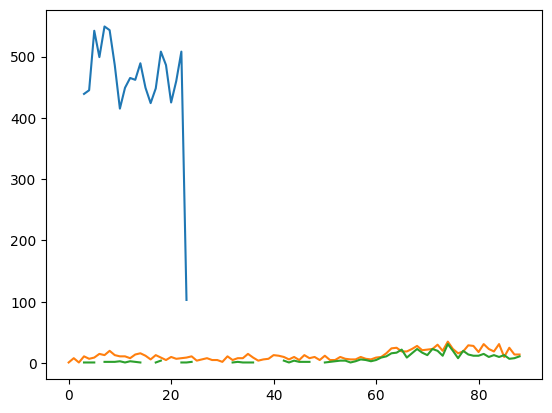

In [101]:
plt.plot(monthly_inmate_incidents.index,monthly_inmate_incidents.iloc[:,2:5])

In [35]:
monthly_inmate_incidents.to_csv('../Data/monthly_inmate_incidents.csv')

#### Covariate 5: Arraignment Data

This data is stored outside of this repository due to privacy constraints

In [52]:
file_path = r"C:\Users\emjoh\OneDrive\Documents\DCJ Shared Drive Data\NYC_Arr_2018_2022.csv"

In [66]:
nyc_arr = pd.read_csv(file_path, index_col = 0)
nyc_arr.head()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_4088\1844615090.py:1: DtypeWarning: Columns (16,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,53) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_arr = pd.read_csv(file_path, index_col = 0)


,ginysids,giifid,id,sex,race.ethnicity,age.at.arrest,age.group,zip,county,precinct,...,partial.surety.bond_01,unsecured.app.bond_01,unsecured.surety.bond_01,secured.app.bond_01,secured.surety.bond_01,bail.set.date,cash.set,bail.post.date,cash.posted,comboid
1,B05D354F1CAC5A8DE871899393871D7D8B8F8A77411844...,74603AB7708F4F5C9827B32B298C8603C7E816A82D238D...,F449C676099DDEC1778C0D4485DE1D15F258D9FDE048A3...,Female,White,32.0,25-34,11207.0,Kings,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B05D354F1CAC5A8DE871899393871D7D8B8F8A77411844...
2,635F74C5388A1E49E450DABB542DA242E5330C2587BE54...,18F2265B6D480CBF7AC53559B680B8F739737DFB315A69...,0F541D510893B4F98AC76F3E4232138CC49E09DB657E46...,Male,White,29.0,25-34,NaN,Kings,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635F74C5388A1E49E450DABB542DA242E5330C2587BE54...
3,0329B94DB802E2D9ECDF58396B9933A15B80BAE2BEAF44...,0B15D8ADE603BA5D4A76480A951C17319B457862943814...,9A21D0221EDBAE066CDDB5305F637AEE8DF5FAEB4B2A37...,Male,Black,19.0,18-20,11212.0,Kings,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0329B94DB802E2D9ECDF58396B9933A15B80BAE2BEAF44...
4,635F74C5388A1E49E450DABB542DA242E5330C2587BE54...,9FDF0946900CADA0BB94C5CFB1D508749CC98AAB9D3C49...,741480CF329014CB91D56FD0D0C0269D4DFA0151D7BFEF...,Male,NaN,28.0,25-34,NaN,Kings,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635F74C5388A1E49E450DABB542DA242E5330C2587BE54...
5,635F74C5388A1E49E450DABB542DA242E5330C2587BE54...,6F311200CE42C151E5A295FBACE0291CE50C17FC83613E...,FC2536176635A634B0328BADC34C5A4961270D68F2612D...,Male,NaN,NaN,NaN,NaN,Kings,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635F74C5388A1E49E450DABB542DA242E5330C2587BE54...


In [67]:
nyc_arr.columns

Index(['ginysids', 'giifid', 'id', 'sex', 'race.ethnicity', 'age.at.arrest',
       'age.group', 'zip', 'county', 'precinct', 'arrestdate', 'arrestyr',
       'arrest.charge', 'arrest.charge.class', 'arrest.charge.level',
       'arr.arrgn.days', 'arrgntdate', 'arrgntyr', 'arrgnt.mo',
       'arrgnt.charge', 'arrgnt.charge.attempted', 'arrgnt.charge.class',
       'arrgnt.charge.level', 'arraignment.type', 'arraignment.release.status',
       'datflag', 'vfo', 'dvflag', 'release.status_01', 'release.status_02',
       'release.status_03', 'release.status_04', 'release.status_05',
       'release.status_06', 'release.status_07', 'release.status_08',
       'release.status_09', 'release.status_10', 'first.app.date_01',
       'bail.action.date_01', 'bail.action_01', 'bail.condition_01',
       'bail.condition_02', 'em_01', 'ins.bond_01', 'credit.set_01',
       'partial.app.bond_01', 'partial.surety.bond_01',
       'unsecured.app.bond_01', 'unsecured.surety.bond_01',
       'secured.app

In [68]:
nyc_arr['arraignment.type'].unique()

array(['DAT', 'Pre-arraignment Deposition', 'Regular', 'Criminal Summons',
       'Domestic Violence Case', 'Family Court', 'Hospital Arraignment',
       'Juvenile Violent Felony Offender',
       'Domestic Violence Case - Not Arraigned',
       'Violation of Probation Transfer from Another County',
       'Domestic Violence Case - Hospital Arraignment',
       'Transferred from Summons Part'], dtype=object)

In [69]:
nyc_arr['arraignment.release.status'].unique()

array([nan, 'ROR', 'Bail Not Posted', 'Remand', 'Non-Monetary Conditions',
       'Bail Set'], dtype=object)

In [70]:
#this column seems to hold the charge description we are most interested in
nyc_arr['arrgnt.charge.class'].unique()

array(['A Misdemeanor', 'B Felony', 'Unclassified Misdemeanor',
       'D Felony', 'B Misdemeanor', 'Violation', 'Infraction', 'C Felony',
       'E Felony', nan, 'A Felony'], dtype=object)

In [71]:
nyc_arr['arrgnt.charge.level'].unique()

array(['Misdemeanor', 'Felony', 'Violation', 'Infraction', nan],
      dtype=object)

In [72]:
print(len(nyc_arr['comboid'].unique()),len(nyc_arr['id'].unique()),len(nyc_arr['giifid'].unique()),len(nyc_arr['ginysids'].unique()))

706934 706701 706701 377995


In [73]:
#count the unique ids for each yr-mo and charge class
df = nyc_arr.copy()[['id','arrgnt.charge.level','arrgntdate', 'arrgntyr', 'arrgnt.mo']]
df['arrgnt.charge.level'] = df['arrgnt.charge.level'].fillna('Other')

df.head()

,id,arrgnt.charge.level,arrgntdate,arrgntyr,arrgnt.mo
1,F449C676099DDEC1778C0D4485DE1D15F258D9FDE048A3...,Misdemeanor,7/30/2018,2018,7
2,0F541D510893B4F98AC76F3E4232138CC49E09DB657E46...,Felony,1/2/2018,2018,1
3,9A21D0221EDBAE066CDDB5305F637AEE8DF5FAEB4B2A37...,Misdemeanor,11/26/2018,2018,11
4,741480CF329014CB91D56FD0D0C0269D4DFA0151D7BFEF...,Misdemeanor,3/5/2018,2018,3
5,FC2536176635A634B0328BADC34C5A4961270D68F2612D...,Misdemeanor,4/11/2018,2018,4


In [74]:
monthly_arr = df.groupby(by = ['arrgntyr', 'arrgnt.mo','arrgnt.charge.level']).agg({'id':'nunique'}).reset_index()
monthly_arr = monthly_arr.pivot(index = ['arrgntyr', 'arrgnt.mo'],columns = 'arrgnt.charge.level',values = 'id').reset_index().rename_axis(None, axis=1)
monthly_arr['Total_Arraignments'] = monthly_arr[['Other','Misdemeanor', 'Felony', 'Violation', 'Infraction']].sum(axis = 1)

monthly_arr = monthly_arr.rename(columns = {'arrgntyr':'year',
                                            'arrgnt.mo':'month',
                                           'Other':'Other_ArrChg',
                                            'Misdemeanor':'Misdemeanor_ArrChg',
                                            'Felony':'Felony_ArrChg',
                                            'Violation':'Violation_ArrChg',
                                            'Infraction':'Infraction_ArrChg'})
monthly_arr.head()

,year,month,Felony_ArrChg,Infraction_ArrChg,Misdemeanor_ArrChg,Other_ArrChg,Violation_ArrChg,Total_Arraignments
0,2018,1,3406,155,16328,65,437,20391
1,2018,2,3141,141,14384,64,440,18170
2,2018,3,3276,157,15493,64,388,19378
3,2018,4,3162,149,14286,60,399,18056
4,2018,5,3454,160,14517,59,459,18649


In [75]:
monthly_arr.to_csv('../Data/monthly_arr_by_charge_level.csv')

In [83]:
#count the unique ids for each yr-mo and release status
df = nyc_arr.copy()[['id','arraignment.release.status','arrgntdate', 'arrgntyr', 'arrgnt.mo']]
df.head()

,id,arraignment.release.status,arrgntdate,arrgntyr,arrgnt.mo
1,F449C676099DDEC1778C0D4485DE1D15F258D9FDE048A3...,NaN,7/30/2018,2018,7
2,0F541D510893B4F98AC76F3E4232138CC49E09DB657E46...,ROR,1/2/2018,2018,1
3,9A21D0221EDBAE066CDDB5305F637AEE8DF5FAEB4B2A37...,NaN,11/26/2018,2018,11
4,741480CF329014CB91D56FD0D0C0269D4DFA0151D7BFEF...,NaN,3/5/2018,2018,3
5,FC2536176635A634B0328BADC34C5A4961270D68F2612D...,ROR,4/11/2018,2018,4


In [84]:
df['arraignment.release.status'] = df['arraignment.release.status'].fillna('Other')
df.head()

,id,arraignment.release.status,arrgntdate,arrgntyr,arrgnt.mo
1,F449C676099DDEC1778C0D4485DE1D15F258D9FDE048A3...,Other,7/30/2018,2018,7
2,0F541D510893B4F98AC76F3E4232138CC49E09DB657E46...,ROR,1/2/2018,2018,1
3,9A21D0221EDBAE066CDDB5305F637AEE8DF5FAEB4B2A37...,Other,11/26/2018,2018,11
4,741480CF329014CB91D56FD0D0C0269D4DFA0151D7BFEF...,Other,3/5/2018,2018,3
5,FC2536176635A634B0328BADC34C5A4961270D68F2612D...,ROR,4/11/2018,2018,4


In [85]:
monthly_arr = df.groupby(by = ['arrgntyr', 'arrgnt.mo','arraignment.release.status']).agg({'id':'nunique'}).reset_index()
monthly_arr = monthly_arr.pivot(index = ['arrgntyr', 'arrgnt.mo'],columns = 'arraignment.release.status',values = 'id').reset_index().rename_axis(None, axis=1)
monthly_arr['Total_Arraignments'] = monthly_arr[['Other','ROR', 'Bail Not Posted', 'Remand', 'Non-Monetary Conditions','Bail Set']].sum(axis = 1)

monthly_arr = monthly_arr.rename(columns = {'arrgntyr':'year',
                                            'arrgnt.mo':'month',
                                            'Other': 'Other_ArrRel',
                                            'ROR':'ROR_ArrRel',
                                            'Bail Not Posted':'BailNotPosted_ArrRel',
                                            'Remand':'Remand_ArrRel',
                                            'Non-Monetary Conditions':'NonMonetaryCondit_ArrRel',
                                            'Bail Set':'BailPosted_ArrRel'
                                          })
monthly_arr.head()

,year,month,BailNotPosted_ArrRel,BailPosted_ArrRel,NonMonetaryCondit_ArrRel,Other_ArrRel,ROR_ArrRel,Remand_ArrRel,Total_Arraignments
0,2018,1,2684,369,426,5921,10866,125,20391
1,2018,2,2290,334,413,4773,10244,116,18170
2,2018,3,2332,392,461,5037,11058,97,19377
3,2018,4,2291,413,465,4608,10184,95,18056
4,2018,5,2487,419,493,4579,10571,101,18650


In [86]:
monthly_arr.to_csv('../Data/monthly_arr_by_release_status.csv')

## Join all data and conduct feature selection

In [2]:
#IVs
arr_rel = pd.read_csv('../Data/monthly_arr_by_release_status.csv',index_col = 0)
arr_chrg = pd.read_csv('../Data/monthly_arr_by_charge_level.csv',index_col = 0)
inmate_inc = pd.read_csv('../Data/monthly_inmate_incidents.csv',index_col = 0)
crime = pd.read_csv('../Data/monthly_crime_counts_by_type.csv',index_col = 0)
staff_assualts = pd.read_csv('../Data/monthly_assaults_on_DOC_staff.csv',index_col = 0)

In [8]:
arr_rel.tail(1)

,year,month,BailNotPosted_ArrRel,BailPosted_ArrRel,NonMonetaryCondit_ArrRel,Other_ArrRel,ROR_ArrRel,Remand_ArrRel,Total_Arraignments
60,2023,1,38,3,37,32,163,6,279


In [3]:
#DV
monthly_jailpop = pd.read_csv('../Data/monthly_admit_discharge_popchange_14to23.csv',index_col = 0)
monthly_jailpop = monthly_jailpop[['year','month','Gain/Loss']]
monthly_jailpop = monthly_jailpop.rename(columns = {'Gain/Loss':'JailPop_Change'})

In [4]:
#inner join jail pop and arraignment data first bc this is the most recent timeframe
combined_df = pd.merge(monthly_jailpop,arr_rel,how = 'inner', on = ['year','month'])

In [5]:
#now just left joins
df_ls = [arr_chrg,crime,staff_assualts,inmate_inc]

for df in df_ls:
    combined_df = pd.merge(combined_df,df,how = 'left', on = ['year','month'])
    
combined_df.head()

,year,month,JailPop_Change,BailNotPosted_ArrRel,BailPosted_ArrRel,NonMonetaryCondit_ArrRel,Other_ArrRel,ROR_ArrRel,Remand_ArrRel,Total_Arraignments_x,...,Total_Arraignments_y,Felony_Crimes,Misdemeanor_Crimes,Violation_Crimes,Total_Crimes,Staff_Assaults,Inmate_Fight,Inmate_Slashing,Inmate_Stabbing,Total_Inmate_Incidents
0,2018,1,351,2684,369,426,5921,10866,125,20391,...,20391,11301,20920,5451,37672,269.0,NaN,11.0,2.0,13.0
1,2018,2,-46,2290,334,413,4773,10244,116,18170,...,18170,10174,19206,5194,34574,263.0,NaN,4.0,NaN,4.0
2,2018,3,-312,2332,392,461,5037,11058,97,19377,...,19378,11119,20643,5607,37369,235.0,NaN,6.0,1.0,7.0
3,2018,4,23,2291,413,465,4608,10184,95,18056,...,18056,10894,20872,5699,37465,179.0,NaN,8.0,NaN,8.0
4,2018,5,-239,2487,419,493,4579,10571,101,18650,...,18649,12378,22153,6625,41156,224.0,NaN,5.0,NaN,5.0


In [6]:
#drop the duplicate total arraignment and Inmate Fights (lack of reporting) column and fill nans with 0
combined_df = combined_df.drop(columns = ['Total_Arraignments_y','Inmate_Fight'])
combined_df = combined_df.rename(columns = {'Total_Arraignments_x':'Total_Arraignments'})
combined_df = combined_df.fillna(0)

In [7]:
#save before scaling
combined_df.to_csv('../Data/exo_variables_and_jailpop_monthly.csv')

In [58]:
#standardize all variables 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the selected columns
scaled_data = scaler.fit_transform(combined_df[combined_df.columns.to_list()[2:]])

# Create a new DataFrame with the scaled data
scaled_combined_df = pd.DataFrame(data=scaled_data, columns=combined_df.columns.to_list()[2:])
#also want to look at the 1 month lag as a variable as well
shifted_df = pd.DataFrame(data=scaled_combined_df.shift(1), columns=combined_df.columns.to_list()[2:])
#merge on index
scaled_combined_df = pd.merge(scaled_combined_df,shifted_df,left_index = True,right_index=True, suffixes = ['','_lag1'])
# Add the 'year' and 'month' columns back to the scaled DataFrame
scaled_combined_df[['year', 'month']] = combined_df[['year', 'month']]
scaled_combined_df.head()

,JailPop_Change,BailNotPosted_ArrRel,BailPosted_ArrRel,NonMonetaryCondit_ArrRel,Other_ArrRel,ROR_ArrRel,Remand_ArrRel,Total_Arraignments,Felony_ArrChg,Infraction_ArrChg,...,Felony_Crimes_lag1,Misdemeanor_Crimes_lag1,Violation_Crimes_lag1,Total_Crimes_lag1,Staff_Assaults_lag1,Inmate_Slashing_lag1,Inmate_Stabbing_lag1,Total_Inmate_Incidents_lag1,year,month
0,1.480277,2.186597,1.642157,-0.829507,2.949445,1.788751,0.044716,2.177962,1.568071,1.431988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1
1,-0.090689,1.500029,1.336942,-0.851883,2.046940,1.516559,-0.240736,1.628395,1.076557,1.151824,...,-0.635946,0.420891,-1.012979,-0.188101,2.802293,-0.325624,-0.664341,-0.505548,2018,2
2,-1.143275,1.573216,1.842727,-0.769262,2.254484,1.872771,-0.843356,1.927057,1.326951,1.472011,...,-1.309060,-0.337739,-1.380090,-0.896177,2.729738,-1.143515,-0.923286,-1.078990,2018,3
3,0.182351,1.501771,2.025856,-0.762377,1.917224,1.490303,-0.906789,1.600187,1.115507,1.311918,...,-0.744648,0.298289,-0.790141,-0.257354,2.391147,-0.909831,-0.793814,-0.887843,2018,4
4,-0.854408,1.843313,2.078179,-0.714182,1.894426,1.659657,-0.716488,1.747167,1.657100,1.532047,...,-0.879032,0.399646,-0.658724,-0.235412,1.713966,-0.676148,-0.923286,-0.824127,2018,5


In [59]:
#save to data
scaled_combined_df.to_csv('../Data/scaled_exo_variables_and_jailpop_monthly.csv')

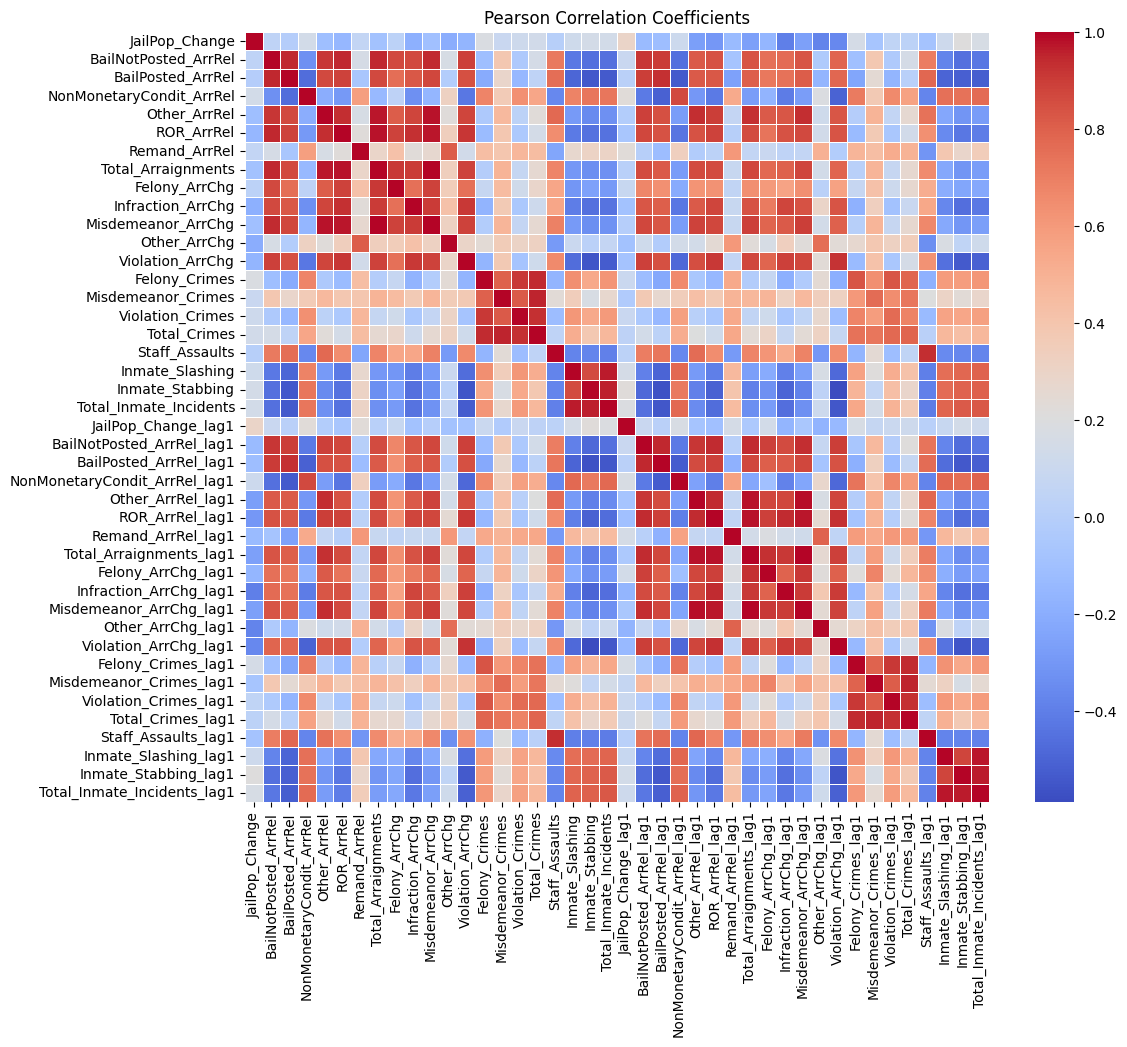

In [10]:
# Compute the correlation matrix
correlation_matrix = scaled_combined_df[scaled_combined_df.columns.to_list()[:-2]].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sn.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation Coefficients')
plt.show()

In [11]:
# Get the correlation coefficients with 'JailPop_Change'
jailpop_change_corr = correlation_matrix['JailPop_Change'].drop('JailPop_Change')
top_10_correlated = jailpop_change_corr.abs().nlargest(15)

# Print the top 10 most correlated variables and their correlation coefficients
for variable, correlation in top_10_correlated.items():
    print(f"Variable: {variable}")
    print(f"Correlation Coefficient: {correlation}")
    print()


Variable: Infraction_ArrChg_lag1
Correlation Coefficient: 0.3956480135118419

Variable: Other_ArrChg_lag1
Correlation Coefficient: 0.37935811195061764

Variable: Violation_ArrChg_lag1
Correlation Coefficient: 0.36117575758842235

Variable: ROR_ArrRel_lag1
Correlation Coefficient: 0.30048080726108195

Variable: JailPop_Change_lag1
Correlation Coefficient: 0.2943338550050536

Variable: Other_ArrRel_lag1
Correlation Coefficient: 0.2683047277323589

Variable: Misdemeanor_ArrChg_lag1
Correlation Coefficient: 0.2649723121326232

Variable: Total_Arraignments_lag1
Correlation Coefficient: 0.26374982472854286

Variable: Inmate_Stabbing_lag1
Correlation Coefficient: 0.20984917133654019

Variable: Other_ArrChg
Correlation Coefficient: 0.1997559379297294

Variable: Infraction_ArrChg
Correlation Coefficient: 0.18708925727384562

Variable: Felony_Crimes
Correlation Coefficient: 0.1831469521448947

Variable: Total_Inmate_Incidents_lag1
Correlation Coefficient: 0.16446009112444815

Variable: Violation

Based on subject matter expertise, the following covariates should be considered in our model:


1. **JailPop_Change_lag1:** Jail Population Change from the previous month

2. **Total_Arraignments_lag1:** Total arraignments from the previous month

3. **Inmate_Stabbing_lag1:** Inmate stabbings from the previous month, note their is multicolinearity between this variable and Total_Inmate_incidents_lag1 (number 5)

4. **Felony_Crimes:** The number of crimes reported to the NYPD in a given month, categorized as a felony (manslaughter or murder, aggravated assault, kidnapping, drug related offenses, etc.)

5. **Total_Inmate_Incidents_lag1:** All inmate incidents from the previous month (includes stabbing and slashing)

In [16]:
#lets grab these features and do a linear regression to see p-values
features = ['JailPop_Change_lag1','Total_Arraignments_lag1','Inmate_Stabbing_lag1','Felony_Crimes']
scaled_combined_df = scaled_combined_df.sort_values(by = ['year','month'])
x_data = scaled_combined_df[features]
y_data = scaled_combined_df['JailPop_Change']

In [18]:
import statsmodels.api as sm

lm=sm.OLS(y_data,x_data,missing = 'drop').fit()
print (lm.summary())

                                 OLS Regression Results                                
Dep. Variable:         JailPop_Change   R-squared (uncentered):                   0.180
Model:                            OLS   Adj. R-squared (uncentered):              0.122
Method:                 Least Squares   F-statistic:                              3.082
Date:                Thu, 06 Jul 2023   Prob (F-statistic):                      0.0230
Time:                        14:55:08   Log-Likelihood:                         -78.566
No. Observations:                  60   AIC:                                      165.1
Df Residuals:                      56   BIC:                                      173.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [19]:
scaled_combined_df.columns

Index(['JailPop_Change', 'BailNotPosted_ArrRel', 'BailPosted_ArrRel',
       'NonMonetaryCondit_ArrRel', 'Other_ArrRel', 'ROR_ArrRel',
       'Remand_ArrRel', 'Total_Arraignments', 'Felony_ArrChg',
       'Infraction_ArrChg', 'Misdemeanor_ArrChg', 'Other_ArrChg',
       'Violation_ArrChg', 'Felony_Crimes', 'Misdemeanor_Crimes',
       'Violation_Crimes', 'Total_Crimes', 'Staff_Assaults', 'Inmate_Slashing',
       'Inmate_Stabbing', 'Total_Inmate_Incidents', 'JailPop_Change_lag1',
       'BailNotPosted_ArrRel_lag1', 'BailPosted_ArrRel_lag1',
       'NonMonetaryCondit_ArrRel_lag1', 'Other_ArrRel_lag1', 'ROR_ArrRel_lag1',
       'Remand_ArrRel_lag1', 'Total_Arraignments_lag1', 'Felony_ArrChg_lag1',
       'Infraction_ArrChg_lag1', 'Misdemeanor_ArrChg_lag1',
       'Other_ArrChg_lag1', 'Violation_ArrChg_lag1', 'Felony_Crimes_lag1',
       'Misdemeanor_Crimes_lag1', 'Violation_Crimes_lag1', 'Total_Crimes_lag1',
       'Staff_Assaults_lag1', 'Inmate_Slashing_lag1', 'Inmate_Stabbing_lag1',
  

In [51]:
#let's hand pick the variables that we think are the most impactful to jail population change
#felony arraignments, last month's arraignments, last month's jail population, inmate incidents,
#Remand and bail not posted arraignment release statuses, felony arraignments 
features = ['JailPop_Change_lag1','Total_Arraignments_lag1','BailNotPosted_ArrRel','Remand_ArrRel']
x_data = scaled_combined_df[features]
lm=sm.OLS(y_data,x_data,missing = 'drop').fit()
print (lm.summary())

                                 OLS Regression Results                                
Dep. Variable:         JailPop_Change   R-squared (uncentered):                   0.275
Model:                            OLS   Adj. R-squared (uncentered):              0.224
Method:                 Least Squares   F-statistic:                              5.396
Date:                Thu, 06 Jul 2023   Prob (F-statistic):                    0.000936
Time:                        16:35:01   Log-Likelihood:                         -76.761
No. Observations:                  61   AIC:                                      161.5
Df Residuals:                      57   BIC:                                      170.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [52]:
features = ['BailNotPosted_ArrRel','Total_Arraignments_lag1']
x_data = scaled_combined_df[features]
lm=sm.OLS(y_data,x_data,missing = 'drop').fit()
print (lm.summary())

                                 OLS Regression Results                                
Dep. Variable:         JailPop_Change   R-squared (uncentered):                   0.233
Model:                            OLS   Adj. R-squared (uncentered):              0.207
Method:                 Least Squares   F-statistic:                              8.965
Date:                Thu, 06 Jul 2023   Prob (F-statistic):                    0.000398
Time:                        16:35:35   Log-Likelihood:                         -78.462
No. Observations:                  61   AIC:                                      160.9
Df Residuals:                      59   BIC:                                      165.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [62]:
#lets also add dummy variables for the month column
features = ['BailNotPosted_ArrRel','Total_Arraignments_lag1']
x_data = pd.concat([scaled_combined_df[features],pd.get_dummies(scaled_combined_df['month'],drop_first=False,dtype=float)],axis = 1)

lm=sm.OLS(y_data,x_data,missing = 'drop').fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:         JailPop_Change   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     3.271
Date:                Thu, 06 Jul 2023   Prob (F-statistic):            0.00147
Time:                        16:48:43   Log-Likelihood:                -64.877
No. Observations:                  60   AIC:                             157.8
Df Residuals:                      46   BIC:                             187.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
BailNotPosted_ArrRel      

In [66]:
#all features, collinearity doesn't matter for decision trees
features = scaled_combined_df.columns.to_list()[1:-2]
print(features)

['BailNotPosted_ArrRel', 'BailPosted_ArrRel', 'NonMonetaryCondit_ArrRel', 'Other_ArrRel', 'ROR_ArrRel', 'Remand_ArrRel', 'Total_Arraignments', 'Felony_ArrChg', 'Infraction_ArrChg', 'Misdemeanor_ArrChg', 'Other_ArrChg', 'Violation_ArrChg', 'Felony_Crimes', 'Misdemeanor_Crimes', 'Violation_Crimes', 'Total_Crimes', 'Staff_Assaults', 'Inmate_Slashing', 'Inmate_Stabbing', 'Total_Inmate_Incidents', 'JailPop_Change_lag1', 'BailNotPosted_ArrRel_lag1', 'BailPosted_ArrRel_lag1', 'NonMonetaryCondit_ArrRel_lag1', 'Other_ArrRel_lag1', 'ROR_ArrRel_lag1', 'Remand_ArrRel_lag1', 'Total_Arraignments_lag1', 'Felony_ArrChg_lag1', 'Infraction_ArrChg_lag1', 'Misdemeanor_ArrChg_lag1', 'Other_ArrChg_lag1', 'Violation_ArrChg_lag1', 'Felony_Crimes_lag1', 'Misdemeanor_Crimes_lag1', 'Violation_Crimes_lag1', 'Total_Crimes_lag1', 'Staff_Assaults_lag1', 'Inmate_Slashing_lag1', 'Inmate_Stabbing_lag1', 'Total_Inmate_Incidents_lag1']


In [67]:
#look into feature importance with the exogenous variables and jail pop change
from sklearn.ensemble import RandomForestRegressor
#train on first 55 months
scaled_combined_df = scaled_combined_df.fillna(0)
X_train = scaled_combined_df.iloc[:55][features]
y_train = scaled_combined_df.iloc[:55]['JailPop_Change']
forest = RandomForestRegressor(random_state=123)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

In [68]:
#feature importance based on impurity
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

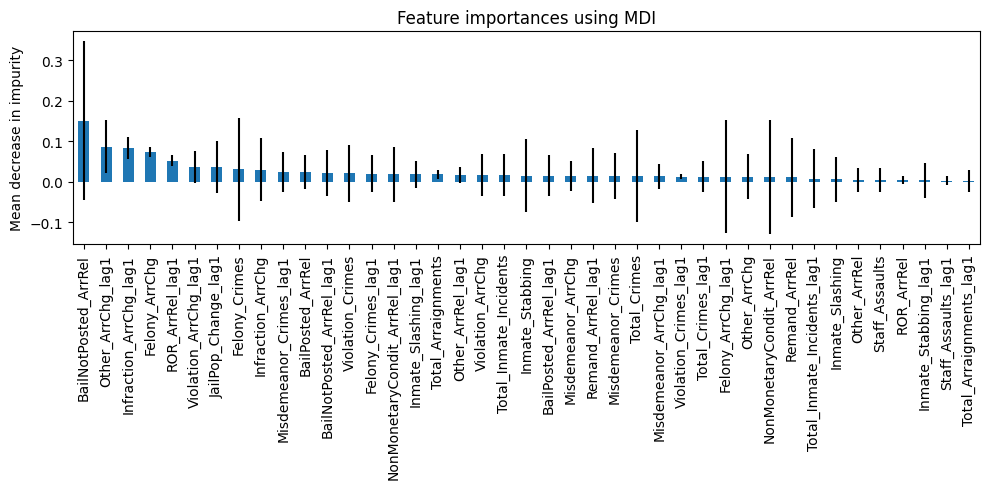

In [69]:
forest_importances = pd.Series(importances, index=features).sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [70]:
from sklearn.inspection import permutation_importance
X_test = scaled_combined_df.iloc[55:][features]
y_test = scaled_combined_df.iloc[55:]['JailPop_Change']
result = permutation_importance(
    forest, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=features).sort_values()

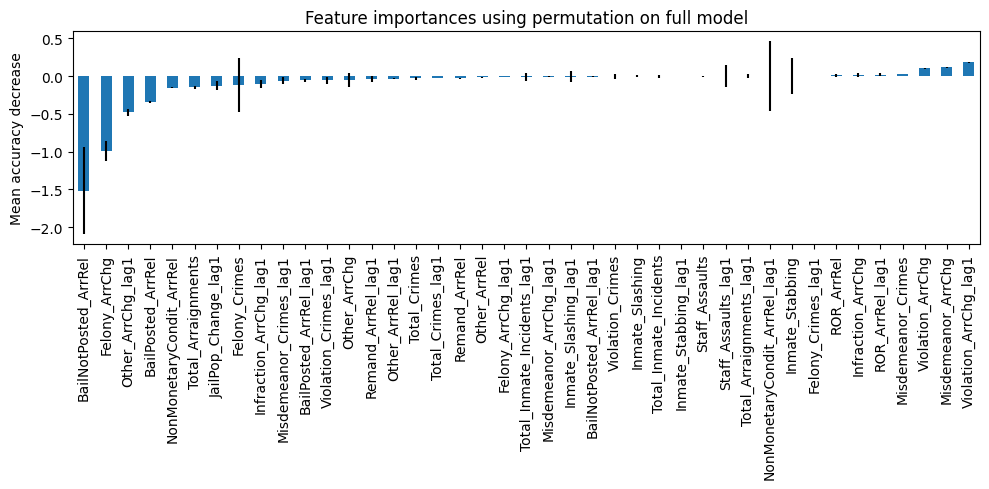

In [71]:
fig, ax = plt.subplots(figsize = (10,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [72]:
#lets try doing feature importance again but this time with the month dummy variables
#train on first 55 months
scaled_combined_df = scaled_combined_df.fillna(0)
X_train = scaled_combined_df.iloc[:55][features]
X_train = pd.concat([X_train,pd.get_dummies(scaled_combined_df.iloc[:55]['month'],drop_first=False,dtype=float)],axis = 1)
X_train.columns = X_train.columns.astype(str)
y_train = scaled_combined_df.iloc[:55]['JailPop_Change']
forest = RandomForestRegressor(random_state=123)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

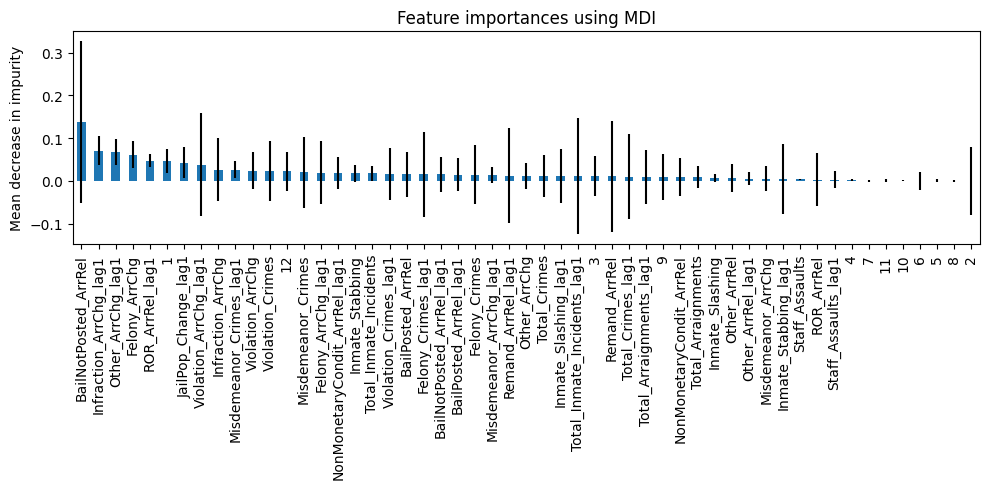

In [73]:
#feature importance based on impurity
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()